In [1]:
import pandas as pd
import pickle
from utils.dataset import labels2cat
from utils import text, eval_ml, prod

In [2]:
# Load vocabulary, term set, pre-trained model and probability threshold
with open("../models/classifier_dev.sav", 'rb') as f:
    MODEL = pickle.load(f)
with open("../models/vocab_dev.sav", 'rb') as f:
    VOCAB = pickle.load(f) 
with open("../models/termset_dev.sav", 'rb') as f:
    TERMSET = pickle.load(f) 
with open("../models/thresh_dev.txt", 'r') as f:
    THRESH = float(f.read())

In [3]:
# Path to unseen data
PATH = "../datasets/"
FILENAME = "reports_test"

EVAL = True

In [4]:
# Load dataset of unseen reports
df = pd.read_csv(PATH + FILENAME + ".csv")
print("Processing %d histopathology reports..." % df.shape[0])

# Rename label column
df.rename(columns={'y_report': 'y'}, inplace=True)

# Convert labels to categorical
df.y = labels2cat(df.y)

# Clean text
df['clean_text'] = df.order_results.apply(text.clean_text)

# Load NLP pipeline
nlp = text.build_nlp_pipeline(TERMSET)

# Match phrases in text to detect concepts
df['doc'] = text.detect_concepts(df.clean_text, nlp, VOCAB)

# Transform predictions to a table of concepts
detected_concepts = text.get_concepts(df)

# Define features
feature_names = MODEL.feature_names_in_
X = text.get_concept_counts(df.histopathology_id, feature_names, detected_concepts)


Processing 52 histopathology reports...


/Users/vrozova/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/IFIS/Analysis/chifir-jbi/code/utils/eval_ml.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  curves = pd.concat([curves,
/Users/vrozova/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/IFIS/Analysis/chifir-jbi/code/utils/eval_ml.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curves.pos_class = curves.pos_class.cat.remove_unused_categories()
/Users/vrozova/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/IFIS/A

Proportion of labels predicted as:
Negative    0.81
Positive    0.19
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       0.98      0.93      0.95        44
    Positive       0.70      0.88      0.78         8

    accuracy                           0.92        52
   macro avg       0.84      0.90      0.87        52
weighted avg       0.93      0.92      0.93        52

PPV: 0.70, Sensitivity: 0.88, Specificity: 0.93


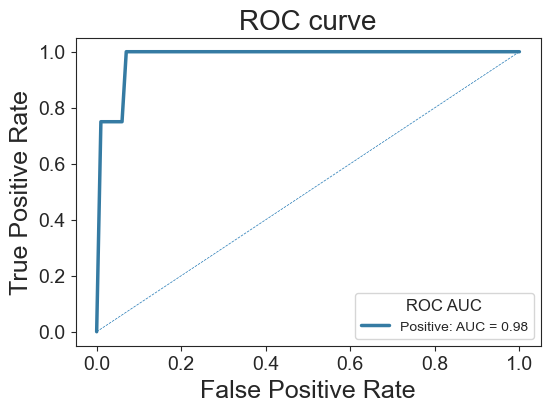

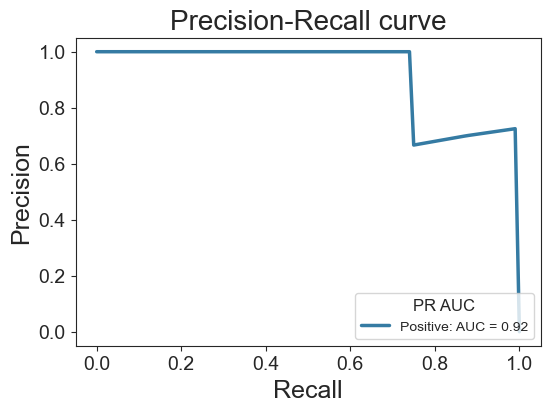

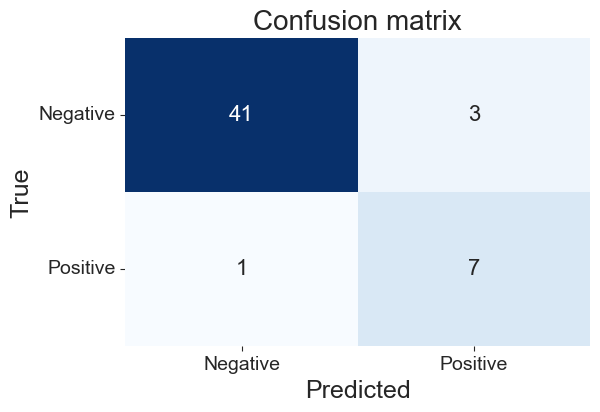

In [5]:
# Make predictions
y_proba = MODEL.predict_proba(X)
# Convert probabilities to class labels
y_pred = prod.proba2class(y_proba, THRESH)

if EVAL:
    # Plot curves
    eval_ml.plot_diagnostic_curves(df.set_index(['histopathology_id', 'val_fold']).y,
                                   y_proba, filename="auto_test")
    # Evaluate classification
    eval_ml.evaluate_classification(df.y, y_pred, filename="auto_test")
else:
    print("Proportion of labels predicted as positive: %.1f%%" % 
          (y_pred.sum() / df.shape[0] * 100))
    
# Save the results
# df.drop(['clean_text', 'doc', 'spans'], axis=1).to_csv(PATH + FILENAME + "_completed.csv", index=False)  